# Für Elise Synthesis, Playback, and Waveform Visualization

This notebook demonstrates:
- Extracting a melody from a MusicXML file (e.g., a transcription of Beethoven's "Für Elise")
- Generating frequencies for notes using an A4 = 440 Hz reference
- Synthesizing sound via sine wave generation with a short fade-in/fade-out envelope
- Optionally generating a richer electronic piano-like tone using harmonics and an ADSR envelope
- Visualizing the generated waveforms using matplotlib

**Requirements:**
- numpy
- simpleaudio
- music21
- matplotlib

You can install these packages with:
```bash
pip install numpy simpleaudio music21 matplotlib
```

In [2]:
import numpy as np
import simpleaudio as sa
import time
from music21 import converter, note, chord
import matplotlib.pyplot as plt
import random

In [3]:
from note_generation import generate_notes
from note_generation import extract_melody


notes_dict = generate_notes(0, 8)
melody = extract_melody('FurElise.xml')
print(melody[:10])

[('E5', 0.5), ('D#5', 0.5), ('E5', 0.5), ('D#5', 0.5), ('E5', 0.5), ('B4', 0.5), ('D5', 0.5), ('C5', 0.5), ('A4', 1.5), ('A2', 0.0)]


In [4]:
from wave_generation import generate_sine_wave
from wave_generation import generate_harmonic_wave
from wave_generation import generate_square_wave
from wave_generation import generate_sawtooth_wave
from wave_generation import generate_triangle_wave
from wave_generation import apply_adsr_envelope
from note_generation import generate_melody_waveform



In [5]:
sample_rate = 44100
attack=0.01
decay=0.1
sustain_level=0.7
release=0.1

harmonics = [1, 0.95, 0.85, 0.25]

def play_audio(audio, sample_rate):
    play_obj = sa.play_buffer(audio, 1, 2, sample_rate)
    play_obj.wait_done()

def play_note(note_str, duration, notes_dict, wave_type = 'sine', sample_rate = 44100):
    """
    Play a single note.
    If note_str is 'rest', it waits silently.
    Otherwise, it looks up the frequency, generates a sine wave, and plays it.
    A tempo adjustment is applied by dividing the duration by 4.
    """
    if duration == 0.0:
        return
    
    if note_str.lower() == "rest":
        time.sleep(duration)
    else:
        frequency = notes_dict.get(note_str)
        if frequency is None:
            print(f"Note {note_str} not found.")
            return
        
        if wave_type == 'sine':
            audio = generate_sine_wave(frequency, duration, sample_rate)
        elif wave_type == 'sine-adsr':
            audio = apply_adsr_envelope(generate_sine_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        elif wave_type == 'harmonic':
            audio = generate_harmonic_wave(frequency, duration, harmonics, sample_rate)
        elif wave_type == 'harmonic-adsr':
            audio = apply_adsr_envelope(generate_harmonic_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        elif wave_type == 'square':
            audio = generate_square_wave(frequency, duration, sample_rate)
        elif wave_type == 'square-adsr':
            audio = apply_adsr_envelope(generate_square_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        elif wave_type == 'sawtooth':
            audio = generate_sawtooth_wave(frequency, duration, sample_rate)
        elif wave_type == 'sawtooth-adsr':
            audio = apply_adsr_envelope(generate_sawtooth_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        elif wave_type == 'triangle':
            audio = generate_triangle_wave(frequency, duration, sample_rate)
        elif wave_type == 'triangle-adsr':
            audio = apply_adsr_envelope(generate_triangle_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        else:
            print(f"Unknown wave type: {wave_type}")
            return
        play_audio(audio, sample_rate)


def play_melody(melody, notes_dict, wave_type = 'sine'):
    """
    Iterate through the melody (list of tuples) and play each note.
    """
    new_wave_type = wave_type
    for note_str, duration in melody:
        print(f"Playing note: {note_str} for {duration} sec with {new_wave_type} wave")
        play_note(note_str, duration, notes_dict, new_wave_type)

melody_waveform = generate_melody_waveform(melody, waveform='sine', harmonics=harmonics, sample_rate=sample_rate, duration_factor=0.5)
play_audio(melody_waveform, sample_rate)
#play_melody(melody, notes_dict, 'harmonic')

Generating waveform for note: E5 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: D#5 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: E5 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: D#5 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: E5 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: B4 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: D5 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: C5 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: A4 with duration: 0.75 (duration factor: 0.5)
Generating waveform for note: C4 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: E4 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: A4 with duration: 0.25 (duration factor: 0.5)
Generating waveform for note: B4 with duration: 0.75 (duration factor: 0.5)
Generating

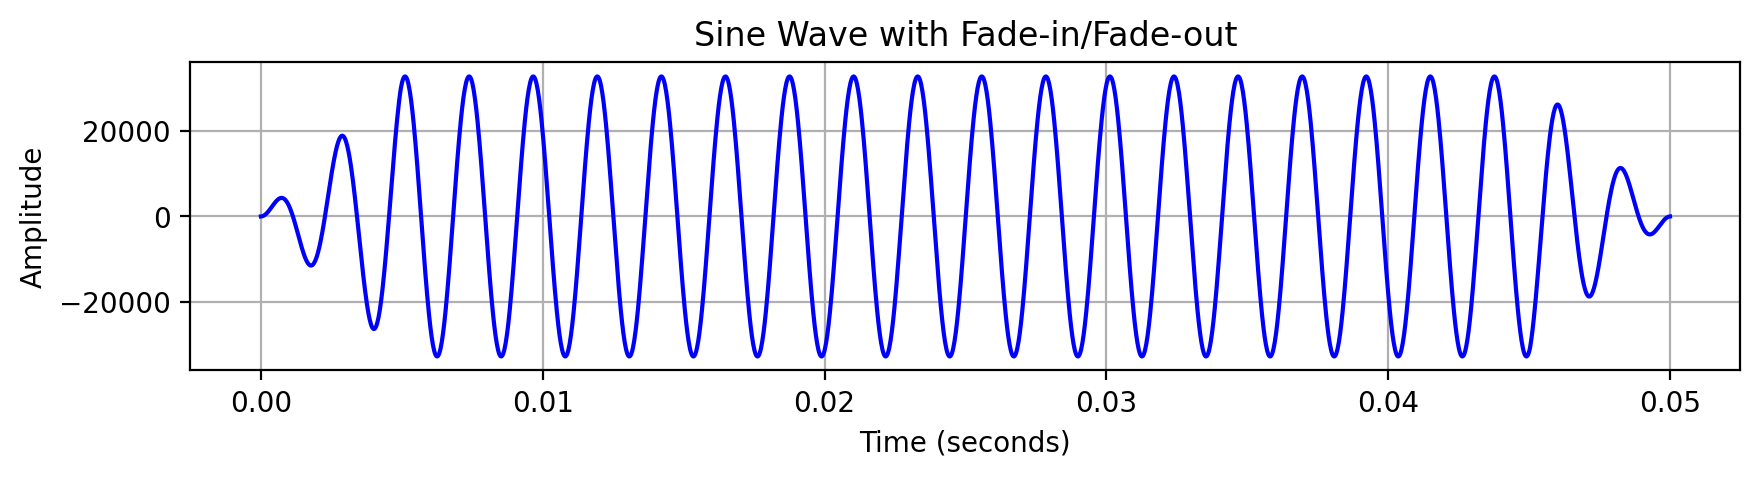

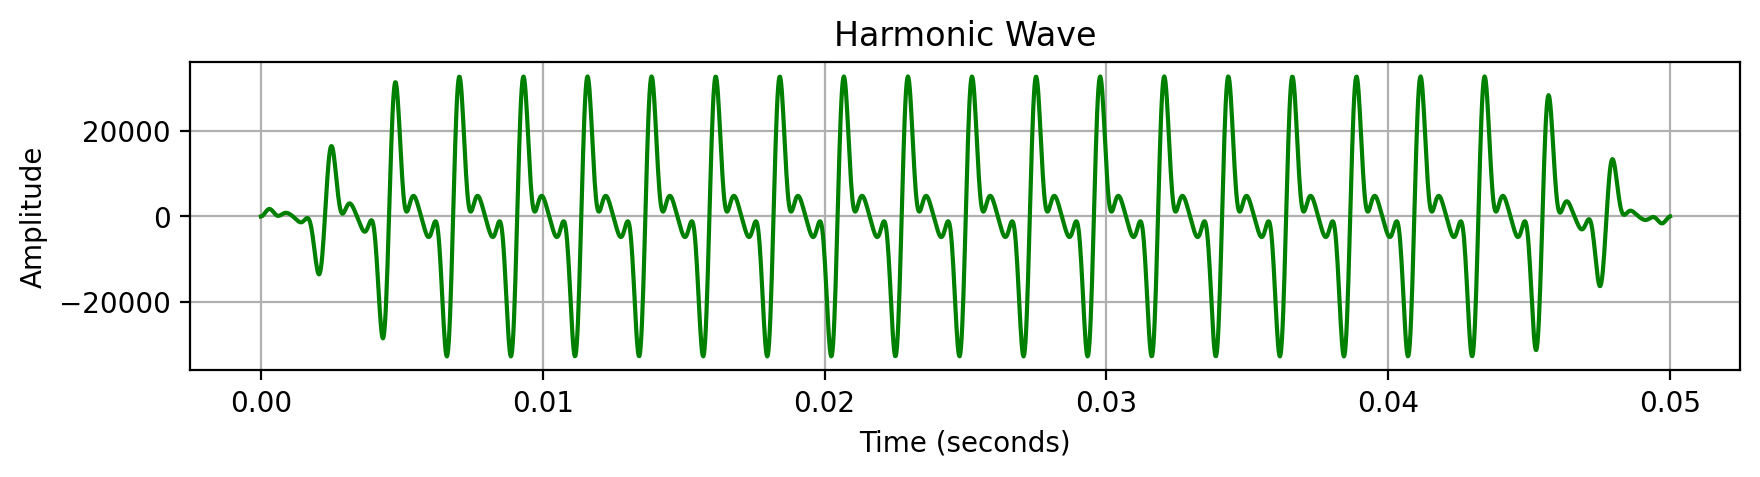

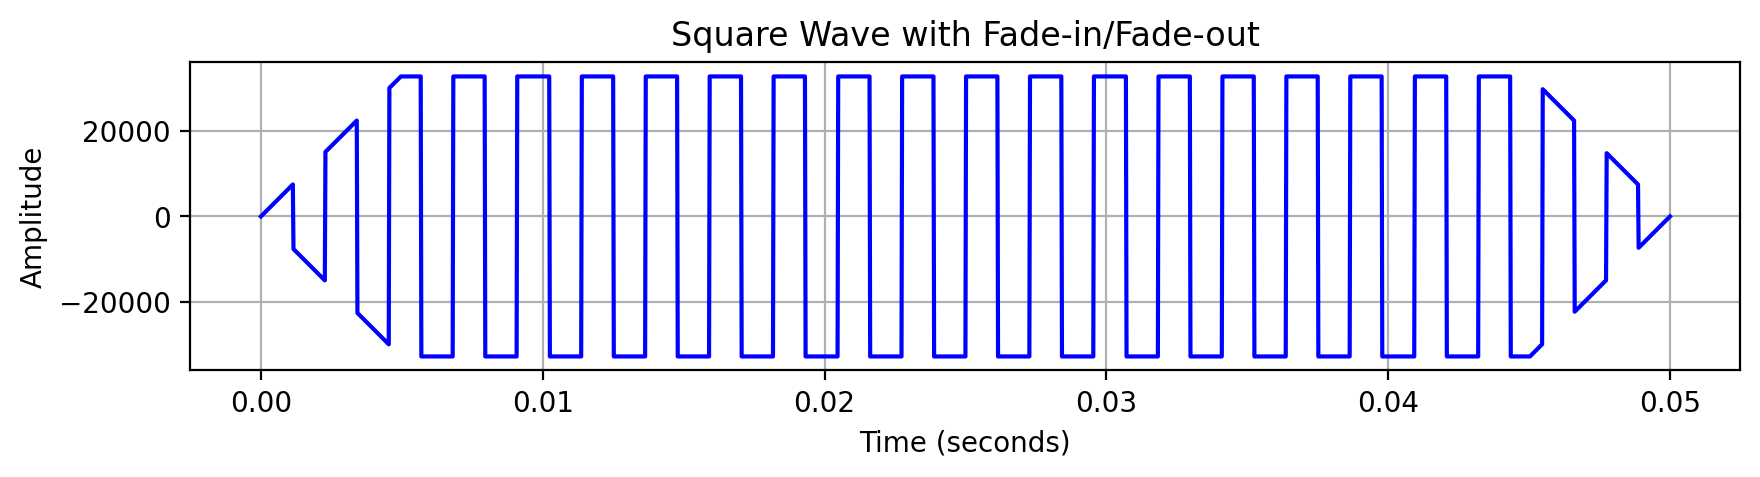

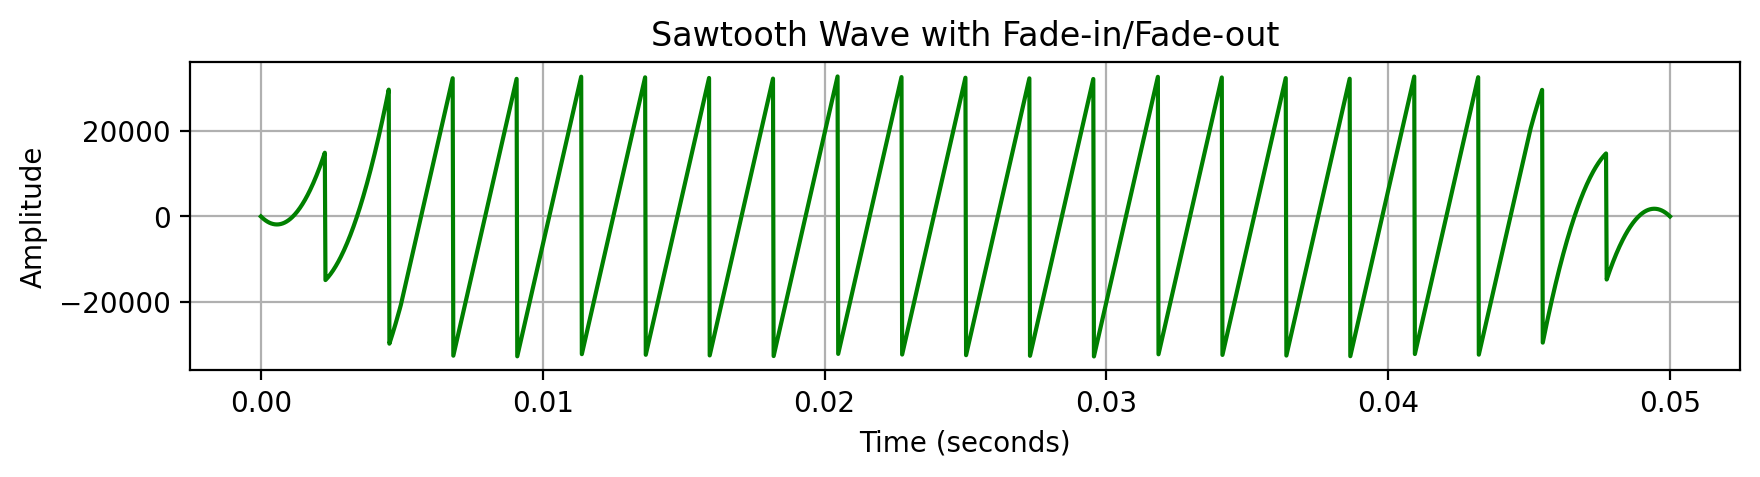

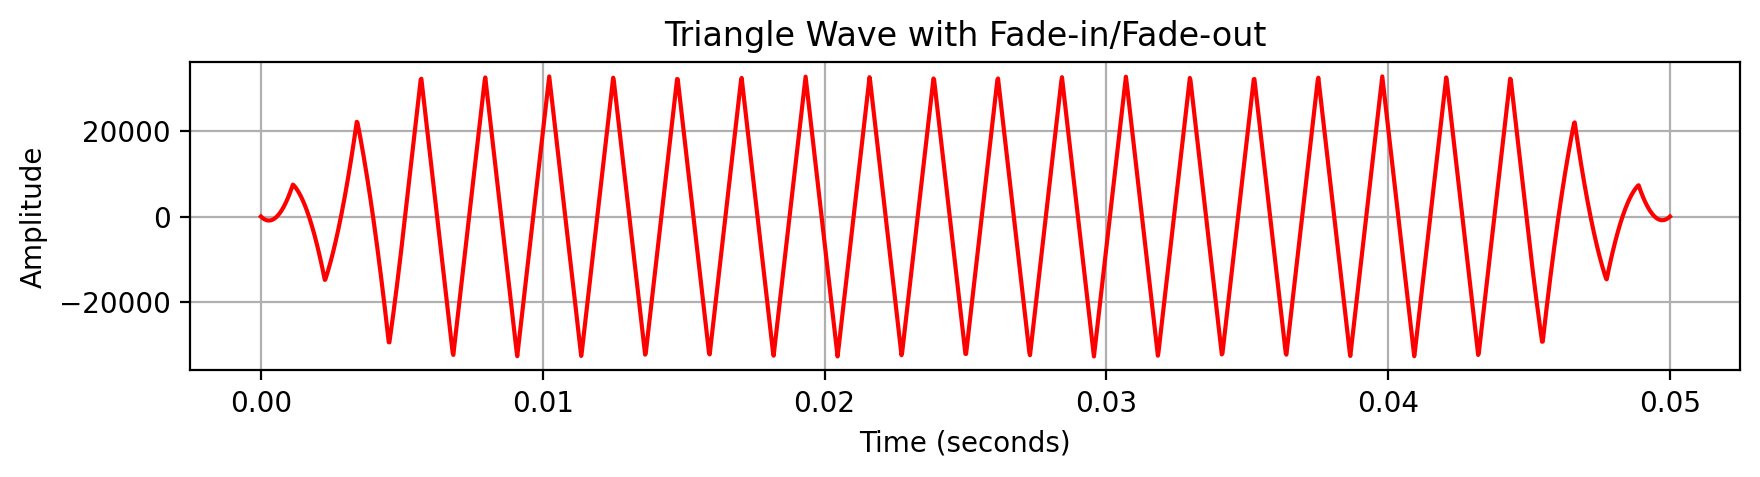

In [6]:
# Visualization of a generated waveform for a given note.
test_frequency = 440  # A4
visual_duration = 0.05  # seconds
sound_duration = 1  # seconds
sample_rate = 44100
attack=0.01
decay=0.1
sustain_level=0.7
release=0.1
# Generate the waveform using the basic sine wave with fade
wave = generate_sine_wave(test_frequency, visual_duration, sample_rate)
time_axis = np.linspace(0, visual_duration, len(wave))

plt.figure(figsize=(10, 2))
plt.plot(time_axis, wave, color='blue')
plt.title("Sine Wave with Fade-in/Fade-out")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_sine_wave(test_frequency, sound_duration, sample_rate), sample_rate)

# wave = apply_adsr_envelope(wave, sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
# time_axis = np.linspace(0, visual_duration, len(wave))

# plt.figure(figsize=(10, 2))
# plt.plot(time_axis, wave, color='blue')
# plt.title("Sine Wave with ADSR Envelope")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Amplitude")
# plt.grid(True)
# plt.show()

# play_audio(wave, sample_rate)

harmonics = [1, 0.95, 0.85, 0.25]
harmonic_wave = generate_harmonic_wave(test_frequency, visual_duration, harmonics)

plt.figure(figsize=(10, 2))
plt.plot(np.linspace(0, visual_duration, len(harmonic_wave)), harmonic_wave, color='green')
plt.title("Harmonic Wave")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_harmonic_wave(test_frequency, sound_duration, harmonics), sample_rate)

# harmonic_wave_adsr = apply_adsr_envelope(harmonic_wave, sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)

# plt.figure(figsize=(10, 2))
# plt.plot(np.linspace(0, visual_duration, len(harmonic_wave_adsr)), harmonic_wave_adsr, color='green')
# plt.title("Harmonic Wave with ASDR Envelope")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Amplitude")
# plt.grid(True)
# plt.show()

# play_audio(harmonic_wave_adsr, sample_rate)

# Generate and plot square wave
square_wave = generate_square_wave(test_frequency, visual_duration, sample_rate=sample_rate)
time_axis = np.linspace(0, visual_duration, len(square_wave))
plt.figure(figsize=(10, 2))
plt.plot(time_axis, square_wave, color='blue')
plt.title("Square Wave with Fade-in/Fade-out")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_square_wave(test_frequency, sound_duration, sample_rate), sample_rate)

# Generate and plot sawtooth wave
sawtooth_wave = generate_sawtooth_wave(test_frequency, visual_duration, sample_rate=sample_rate)
plt.figure(figsize=(10, 2))
plt.plot(np.linspace(0, visual_duration, len(sawtooth_wave)), sawtooth_wave, color='green')
plt.title("Sawtooth Wave with Fade-in/Fade-out")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_sawtooth_wave(test_frequency, sound_duration, sample_rate), sample_rate)

# Generate and plot triangle wave
triangle_wave = generate_triangle_wave(test_frequency, visual_duration, sample_rate=sample_rate)
time_axis = np.linspace(0, visual_duration, len(triangle_wave))
plt.figure(figsize=(10, 2))
plt.plot(time_axis, triangle_wave, color='red')
plt.title("Triangle Wave with Fade-in/Fade-out")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_triangle_wave(test_frequency, sound_duration, sample_rate), sample_rate)

